In [1]:
%pip install pandas
%pip install numpy
%pip install sklearn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 19.3 MB/s eta 0:00:0000:0100:01
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 7.4 MB/s eta 0:00:0000:0100:01m
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
  Running setup.py install for sklearn ... done
Note: you may need to restart the kernel to use updated packages.
  Using cached matplotlib-3.5.2-cp38-cp38-macosx_11_0_arm64.whl (7.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.2-cp38-cp38-macosx_11_0_arm64.whl (63 kB)
  Using cached fonttools-4.33.3-py3-none-any.whl (930 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, recall_score
import copy

In [2]:
# How big is train dataset ?
train_test_ratio = 0.039
np.random.RandomState(seed=42)

data_path = os.path.abspath(os.path.join(os.getcwd(), '..',  'dataset'))

names = pd.read_csv(os.path.join(data_path, 'NUSW-NB15_features_v2.csv'))['Name'].tolist()

frames = []

frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_1.csv"), names=names))
# Uncomment to load all csv
frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_2.csv"), names=names))
frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_3.csv"), names=names))
frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_4.csv"), names=names))

df = pd.concat(frames, axis=0, ignore_index=True)

mask = np.random.rand(len(df)) < train_test_ratio
train = df[mask]
test = df[~mask]

# Clear memory
del df

train.head()

/var/folders/89/tw6vgs4d6zn298w8bdhy95zc0000gn/T/ipykernel_5923/272765066.py:11: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_1.csv"), names=names))
/var/folders/89/tw6vgs4d6zn298w8bdhy95zc0000gn/T/ipykernel_5923/272765066.py:13: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_2.csv"), names=names))


,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
8,59.166.0.5,40726,149.171.126.6,53,udp,CON,0.001126,146,178,31,...,0,6,7,3,1,1,1,1,NaN,0
25,59.166.0.8,24946,149.171.126.2,53,udp,CON,0.001122,132,164,31,...,0,8,3,1,2,2,1,1,NaN,0
61,59.166.0.9,41515,149.171.126.5,53,udp,CON,0.001091,130,162,31,...,0,5,9,2,1,1,1,1,NaN,0
95,175.45.176.2,43850,149.171.126.13,80,tcp,FIN,0.244832,876,9446,62,...,0,3,1,1,1,1,1,1,Exploits,1


In [3]:
# Info about data types and columns
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99105 entries, 0 to 2540030
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   srcip             99105 non-null  object 
 1   sport             99105 non-null  object 
 2   dstip             99105 non-null  object 
 3   dsport            99105 non-null  object 
 4   proto             99105 non-null  object 
 5   state             99105 non-null  object 
 6   dur               99105 non-null  float64
 7   sbytes            99105 non-null  int64  
 8   dbytes            99105 non-null  int64  
 9   sttl              99105 non-null  int64  
 10  dttl              99105 non-null  int64  
 11  sloss             99105 non-null  int64  
 12  dloss             99105 non-null  int64  
 13  service           99105 non-null  object 
 14  Sload             99105 non-null  float64
 15  Dload             99105 non-null  float64
 16  Spkts             99105 non-null  int6

In [4]:
# Count null values in columns
train.isnull().sum()

srcip                   0
sport                   0
dstip                   0
dsport                  0
proto                   0
state                   0
dur                     0
sbytes                  0
dbytes                  0
sttl                    0
dttl                    0
sloss                   0
dloss                   0
service                 0
Sload                   0
Dload                   0
Spkts                   0
Dpkts                   0
swin                    0
dwin                    0
stcpb                   0
dtcpb                   0
smeansz                 0
dmeansz                 0
trans_depth             0
res_bdy_len             0
Sjit                    0
Djit                    0
Stime                   0
Ltime                   0
Sintpkt                 0
Dintpkt                 0
tcprtt                  0
synack                  0
ackdat                  0
is_sm_ips_ports         0
ct_state_ttl            0
ct_flw_http_mthd    52607
is_ftp_login

In [5]:
# How many attacks and normal records do we have ?
train['Label'].value_counts()

0    86606
1    12499
Name: Label, dtype: int64

<BarContainer object of 40 artists>

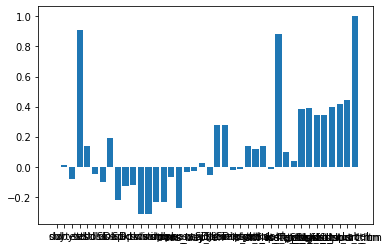

In [6]:
correlation = train.corr()['Label']

plt.bar(correlation.keys(), correlation.tolist())
# plt.show()

In [7]:
corr_dict = correlation.to_dict()
correlation_treshold = 0.2

# Return column names where correlation is greater or equal than threshold
column_names = [key for key, value in corr_dict.items() if abs(value) >= correlation_treshold]
column_names.remove('Label')
column_names

['sttl',
 'Dload',
 'swin',
 'dwin',
 'stcpb',
 'dtcpb',
 'dmeansz',
 'Stime',
 'Ltime',
 'ct_state_ttl',
 'ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm']

In [8]:
scaler = StandardScaler()

X_train = scaler.fit_transform(train[column_names])
y_train = train['Label']
# del train

X_test = scaler.transform(test[column_names])
y_test = test['Label']
# del test

In [9]:
classifiers = {
    'logreg': LogisticRegression(),
    'forest': RandomForestClassifier(),
    'gradboost': GradientBoostingClassifier(),
    'svc': SVC(),
    'mlp': MLPClassifier()
}

In [10]:
results = []
conf_matrix = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    results.append([name, f1, prec, rec, acc])
    conf_matrix[name] = confusion_matrix(y_test, y_pred)
    
df_results = pd.DataFrame(results, columns=['model', 'f1', 'precision', 'recall', 'accuracy'])

/Volumes/ADATASSD512/PWR/Semestr-3/Cyberbezpieczenstwo/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
reg_data = df_results.round(4)

import pickle

# save reg_data results to pickle file
with open('reg_data_results.pickle', 'wb') as f:
    pickle.dump(reg_data, f)



In [16]:
for key, item in conf_matrix.items():
    conf_matrix[key] = item / len(test)

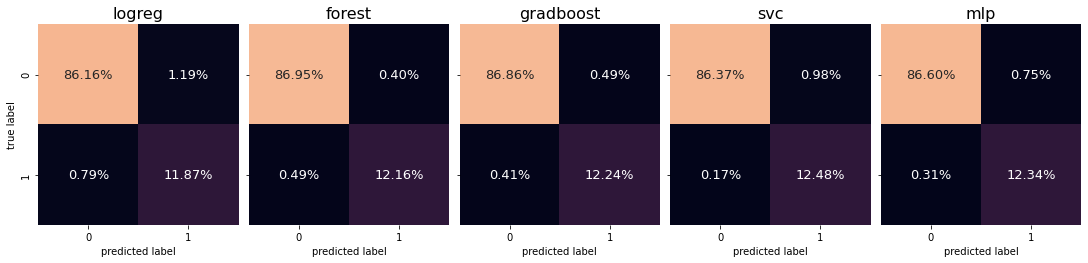

In [24]:
fig, axes = plt.subplots(1, 5, figsize=(15, 6), sharey=True, sharex=True, constrained_layout=True)
axes = axes.flatten()

for i, (model, cm) in enumerate(conf_matrix.items()):
    ax = axes[i]
    sns.heatmap(cm, ax=ax, annot=True, square=True, cbar=False,
                fmt=".2%", vmin=0, vmax=cm.sum().sum(), annot_kws={'size': 13})
    
    ax.set_title(model, fontsize=16)
    ax.margins(0)
    ax.grid(False)
    
    if i == 0:
        ax.set_ylabel('true label')
    ax.set_xlabel('predicted label')

Opisac dane jak go przygotowaliśmy.
Algorytmy
opisac wyniki dla SL i OCSVM
Dalsze prace
Kilka zdan o wynikach w porownaniu do danych zanonimizowanych.

## Anonymized data

In [2]:
# How big is train dataset ?
train_test_ratio = 0.039
np.random.RandomState(seed=42)

data_path = os.path.abspath(os.path.join(os.getcwd(), '..',  'dataset'))

cats = ["srcip","dstip","proto","state","dur","sbytes","dbytes","sttl","dttl","sloss","dloss","service","Sload","Dload","Spkts","Dpkts","swin","dwin","stcpb","dtcpb","smeansz","dmeansz","trans_depth","res_bdy_len","Sjit","Djit","Sintpkt","Dintpkt","tcprtt","synack","ackdat","is_sm_ips_ports","ct_state_ttl","ct_flw_http_mthd","is_ftp_login","ct_ftp_cmd","ct_srv_src","ct_srv_dst","ct_dst_ltm","ct_src_ ltm","ct_src_dport_ltm","ct_dst_sport_ltm","ct_dst_src_ltm","attack_cat","Label"]

# names = pd.read_csv(os.path.join(data_path, 'NUSW-NB15_features_v2.csv'))['Name'].tolist()

df = pd.read_csv(os.path.join(data_path, "UNSW-NB15_1_anonymized_no_col_names.csv"), names=cats)

mask = np.random.rand(len(df)) < train_test_ratio
train = df[mask]
test = df[~mask]

# Clear memory
del df

train.head()

,srcip,dstip,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
10,0.0.0.2,0.0.0.2,arp,INT,0.000000,46,0,0,0,2,...,0,2,2,2,2,2,2,2,Lack,0
14,0.0.0.1,0.0.0.9,udp,CON,0.001851,528,304,31,29,2,...,0,8,4,2,5,1,1,2,Lack,0
108,0.0.0.7,0.0.0.0,udp,CON,0.001185,130,162,31,29,2,...,0,10,13,1,5,3,1,1,Lack,0
146,0.0.0.3,0.0.0.12,tcp,FIN,0.195749,946,268,254,252,8,...,0,1,1,1,1,1,1,1,Exploits,1
162,0.0.0.9,0.0.0.0,udp,CON,0.001098,132,164,31,29,2,...,0,2,13,2,3,1,1,1,Lack,0


<BarContainer object of 39 artists>

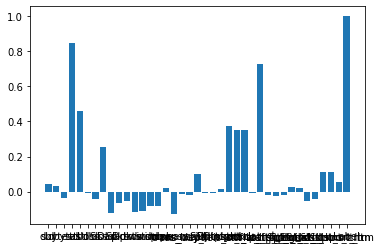

In [3]:
correlation = train.corr()['Label']

plt.bar(correlation.keys(), correlation.tolist())

In [4]:
corr_dict = correlation.to_dict()
correlation_treshold = 0.2

# Return column names where correlation is greater or equal than threshold
column_names = [key for key, value in corr_dict.items() if abs(value) >= correlation_treshold]
column_names.remove('Label')
column_names

['sttl', 'dttl', 'Sload', 'tcprtt', 'synack', 'ackdat', 'ct_state_ttl']

In [5]:
classifiers = {
    'logreg': LogisticRegression(),
    'forest': RandomForestClassifier(),
    'gradboost': GradientBoostingClassifier(),
    'svc': SVC(),
    'mlp': MLPClassifier()
}

In [6]:
scaler = StandardScaler()

X_train = scaler.fit_transform(train[column_names])
y_train = train['Label']
# del train

X_test = scaler.transform(test[column_names])
y_test = test['Label']
# del test

In [7]:
results = []
conf_matrix = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    results.append([name, f1, prec, rec, acc])
    conf_matrix[name] = confusion_matrix(y_test, y_pred)
    
df_results = pd.DataFrame(results, columns=['model', 'f1', 'precision', 'recall', 'accuracy'])

In [8]:
df_results.round(4)




,model,f1,precision,recall,accuracy
0,logreg,0.8692,0.8402,0.9003,0.9914
1,forest,0.9117,0.8808,0.9448,0.9942
2,gradboost,0.9147,0.8686,0.9659,0.9943
3,svc,0.9138,0.8618,0.9724,0.9942
4,mlp,0.9170,0.8602,0.9818,0.9944


In [9]:
for key, item in conf_matrix.items():
    conf_matrix[key] = item / len(test)

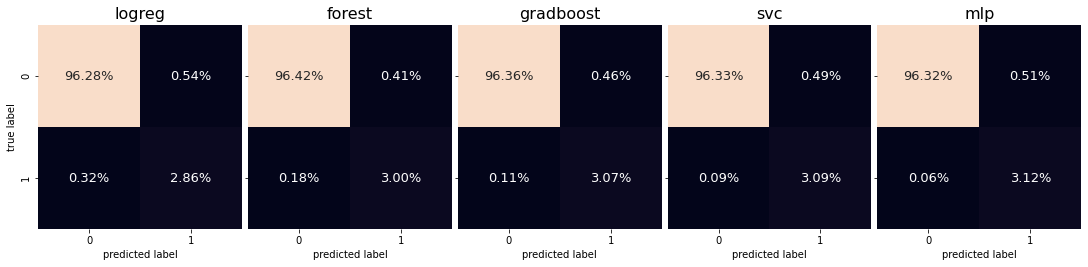

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(15, 6), sharey=True, sharex=True, constrained_layout=True)
axes = axes.flatten()

for i, (model, cm) in enumerate(conf_matrix.items()):
    ax = axes[i]
    sns.heatmap(cm, ax=ax, annot=True, square=True, cbar=False,
                fmt=".2%", vmin=0, vmax=cm.sum().sum(), annot_kws={'size': 13})
    
    ax.set_title(model, fontsize=16)
    ax.margins(0)
    ax.grid(False)
    
    if i == 0:
        ax.set_ylabel('true label')
    ax.set_xlabel('predicted label')

plt.savefig('confusion_matrix.png')
plt.show()

# One Class SVM

Getting highly correlated features to reduce time for training.

In [ ]:
corr_dict = correlation.to_dict()
correlation_treshold_for_OCSVM = 0.6

# Return column names where correlation is greater or equal than threshold
column_names_for_OCSVM = [key for key, value in corr_dict.items() if abs(value) >= correlation_treshold_for_OCSVM]
column_names_for_OCSVM.remove('Label')
column_names_for_OCSVM = [  'dwin',
                            'stcpb',
                            'dtcpb'] # changed for testing

## OCSVM trained on full set of data

OCSVM model trained on both attack and not attack data. It should create a model that labels attacks as outliers (gives them -1).

In [ ]:
# svm One Class

# Load data
x_train = train[column_names_for_OCSVM]
x_test = test[column_names_for_OCSVM]

one_class_svm = OneClassSVM(gamma='auto')
output = one_class_svm.fit_predict(x_train)

In [ ]:
new_output = copy.deepcopy(output)

for count, out in enumerate(output):
    if out == -1:
        new_output[count] = 1
    else:
        new_output[count] = 0

In [ ]:
y_train_output = train['Label']

tn, fp, fn, tp = confusion_matrix(new_output, y_train_output).ravel()
print(f"TP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn} <- attacks not detected")

Model does not detect attacks.

In [ ]:
y_test_output = one_class_svm.predict(test[column_names_for_OCSVM])

In [ ]:
# Good train data (no attacks)

x_train_no_attacts = train[train['Label'] == 0]

x_train_no_attacts = x_train_no_attacts[column_names_for_OCSVM]

one_class_svm_only_good_data = OneClassSVM(gamma='auto')
output_only_good_data = one_class_svm_only_good_data.fit(x_train_no_attacts)

x_train_no_attacts


In [ ]:
# test OCSVM that was trained only on good data

y_test_output_good_data = one_class_svm_only_good_data.predict(test[column_names_for_OCSVM].head(10000))

y_test_output_good_data

In [ ]:
new_y_test_output_good_data = copy.deepcopy(y_test_output_good_data)

for count, out in enumerate(y_test_output_good_data):
    if out == -1:
        new_y_test_output_good_data[count] = 1
    else:
        new_y_test_output_good_data[count] = 0
print(len(new_y_test_output_good_data))
print(np.sum(new_y_test_output_good_data))


In [ ]:
y_label_good_data = test['Label'].head(10000)
tn, fp, fn, tp = confusion_matrix(y_label_good_data, new_y_test_output_good_data).ravel()
print(f"TP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn} <- attacks not detected")

### Results:
One Class SVM for tested features does not detect attacks and is not suitable for detecting network attacks.
It also takes a lot of time to train for higher number of features. 
To create a better OCSVM model we need to find features where distance between attacks and not attacks is highest. That would improve model's accuracy.
